# <font color="blue">Project1: Virtual Makeup </font>
We have already seen interesting applications of facial features and landmarks such as aging, beardify, face swap etc.

In this project, you will build features for a Virtual Makeup application! Given below are a few features that are required to be built in the application. 

1. Apply Lipstick
1. Apply Blush
1. Apply Eye-Liners or Eye-Lashes
1. Apply Glasses
1. Apply Eye Color ( Lens Color)
1. Apply Hat/Cap
1. Apply Ear-Rings
1. Change Hair Color

### <font color="green">Your Task</font>
Implement any 2 features from the list above

We have provided a sample image. You can use your own image for experimentation as well as come up with other interesting features.

### <font color="green">Submission</font>
Once you are done, you have to create a video, explaining the main part of the code, upload it to youtube or any other video sharing service and provide the link in the form given in the submission section of the course.

### <font color="green">Marks Distribution</font>

1. Feature 1: 35 marks
1. Video for Feature 1: 15 marks
1. Feature 2: 35 marks
1. Video for Feature 2: 15 marks

In [5]:
import cv2,sys,dlib,time,math
import numpy as np
import faceBlendCommon as fbc

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (8.0,8.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'

%matplotlib inline

# <font color="blue">Load landmark detector</font>
We have provided code for loading the model for landmark detector.

In [6]:
# Landmark model location
PREDICTOR_PATH =  "shape_predictor_68_face_landmarks.dat"

# Get the face detector
faceDetector = dlib.get_frontal_face_detector()

# The landmark detector is implemented in the shape_predictor class
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

# <font color="blue">Feature 1</font>
Write code for the first feature you want to implement from the above list. Display the output image after writing the code.

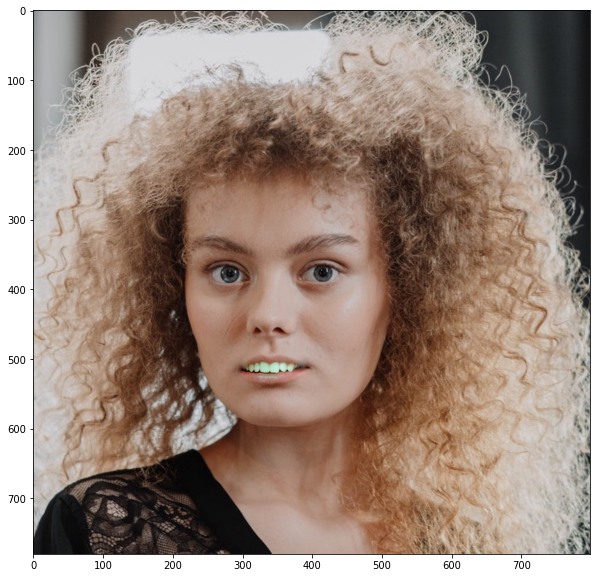

In [31]:
im_1 = cv2.imread("smiling.jpg")
im_2 = cv2.imread("girl-no-makeup.jpg" )   

imDlib_1 = cv2.cvtColor(im_1, cv2.COLOR_BGR2RGB)
imDlib_2 = cv2.cvtColor(im_2, cv2.COLOR_BGR2RGB)
im_Warped = np.copy(imDlib_2)

points_1 = fbc.getLandmarks(faceDetector, landmarkDetector, imDlib_1)
points_2 = fbc.getLandmarks(faceDetector, landmarkDetector, imDlib_2)

selectedIndex = [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]

# Find convex hull
hull1 = []
hull2 = []

for p in selectedIndex:
    hull1.append(points_1[p])
    hull2.append(points_2[p])
    #cv2.circle(imDlib_1, points_1[p], 3, (0, 255, 0), -1)
    #cv2.circle(imDlib_2, points_2[p], 3, (0, 255, 0), -1)
    
    
# find delanauy traingulation for convex hull points
im2_size = im_2.shape
rect = (0, 0, im2_size[1], im2_size[0])

dt = fbc.calculateDelaunayTriangles(rect, hull2)

# apply affine transformation to Delaunay triangles
for i in range(0, len(dt)):
    t1 = []
    t2 = []
    # get points for img1, img2 corresponding to the triangles
    for j in range(0, 3):
        t1.append(hull1[dt[i][j]])
        t2.append(hull2[dt[i][j]])
    fbc.warpTriangle(imDlib_1, im_Warped, t1, t2)
    
# Calculate Mask for Seamless cloning
hull8U = []
for i in range(0, len(hull2)):
    hull8U.append((hull2[i][0], hull2[i][1]))

mask = np.zeros(imDlib_2.shape, dtype=imDlib_2.dtype)
cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))

# find center of the mask to be cloned with the destination image
r = cv2.boundingRect(np.float32([hull2]))
center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))

# Clone seamlessly.
output = cv2.seamlessClone(np.uint8(im_Warped), imDlib_2, mask, center, cv2.NORMAL_CLONE)


plt.figure(figsize = (20, 10))
plt.imshow(output)
plt.show()
    

# <font color="blue">Feature 2</font>

In [36]:
selectedIndex = [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
RESIZE_HEIGHT = 480

# Find convex hull
hull1 = []
hull2 = []
featurePoints1 = []

for p in selectedIndex:
    hull1.append(points_1[p])
    hull2.append(points_2[p])
    #cv2.circle(imDlib_1, points_1[p], 3, (0, 255, 0), -1)
    #cv2.circle(imDlib_2, points_2[p], 3, (0, 255, 0), -1)

    
# Calculate Mask for Seamless cloning
hull8U = []
for i in range(0, len(hull2)):
    hull8U.append((hull2[i][0], hull2[i][1]))

mask = np.zeros(imDlib_2.shape, dtype=imDlib_2.dtype)
cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))

smile_mask = np.float32(mask)
smile = np.float32(imDlib_2)/255

featurePoints2 = hull2

# Find delanauy traingulation for convex hull points
im2_size = imDlib_2.shape
rect = (0, 0, im2_size[1], im2_size[0])
dt = fbc.calculateDelaunayTriangles(rect, featurePoints2)

targetImage = imDlib_1
height, width = targetImage.shape[:2]
IMAGE_RESIZE = np.float32(height)/RESIZE_HEIGHT
targetImage = cv2.resize(targetImage, None, fx=1.0/IMAGE_RESIZE, fy=1.0/IMAGE_RESIZE, interpolation = cv2.INTER_LINEAR)

points1 = hull1
featurePoints1 = []
for p in selectedIndex:
    pt = points2[p]
    pt = fbc.constrainPoint(pt, width, height)
    featurePoints1.append(pt)

targetImage = np.float32(targetImage)/255

beardWarped = np.zeros(targetImage.shape)
beardAlphaWarped = np.zeros(targetImage.shape)

# Apply affine transformation to Delaunay triangles
for i in range(0, len(dt)):
    t1 = []
    t2 = []
    #get points for img1, img2 corresponding to the triangles
    for j in range(0, 3):
        t1.append(featurePoints1[dt[i][j]])
        t2.append(featurePoints2[dt[i][j]])
    fbc.warpTriangle(beard, beardWarped, t1, t2)
    fbc.warpTriangle(beardAlphaMask, beardAlphaWarped, t1, t2)

beardWarpedMask = beardAlphaWarped/255
temp1 = np.multiply(targetImage, 1.0 - beardWarpedMask)
temp2 = np.multiply(beardWarped, beardWarpedMask)

out = temp1 + temp2;
cv2.imshow("out",out);
key = cv2.waitKey(0) & 0xFF



plt.imshow(smile_mask)
plt.show()




NameError: name 'points2' is not defined

# <font color="blue">Feature 3</font>
Write code for the second feature you want to implement from the above list. Display the output image after writing the code.

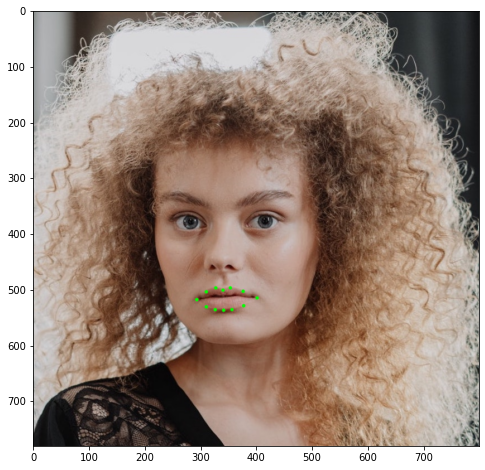

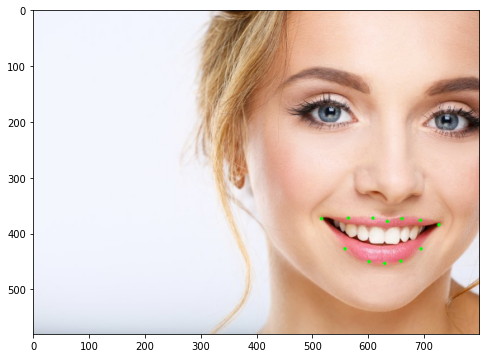

In [23]:
im = cv2.imread("girl-no-makeup.jpg" )   
im_smile = cv2.imread("smiling.jpg")

imDlib = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
imDlib_smile = cv2.cvtColor(im_smile, cv2.COLOR_BGR2RGB)

points_im = fbc.getLandmarks(faceDetector, landmarkDetector, imDlib)
points_smile = fbc.getLandmarks(faceDetector, landmarkDetector, imDlib_smile)


selectedIndex = [48, 49, 50, 51, 52, 53,54,55, 56, 57, 58, 59]

for p in selectedIndex:
    cv2.circle(imDlib, points_im[p], 3, (0, 255, 0), -1)
    cv2.circle(imDlib_smile, points_smile[p], 3, (0, 255, 0), -1)
plt.imshow(imDlib)
plt.show()

plt.imshow(imDlib_smile)
plt.show()